# SentencePiece를 적용해서 네이버 영화리뷰 감정 분석


데이터  
- 200K
- label
    - 0: negative
    - 1: positive
    
- .tsv format

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib
import konlpy
import sentencepiece as spm

print(tf.__version__)
print(np.__version__)
print(matplotlib.__version__)
print(konlpy.__version__)

2.6.0
1.21.4
3.4.3
0.5.2


In [2]:
df = pd.read_csv("./ratings_train.txt", sep="\t")
df

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
...,...,...,...
149995,6222902,인간이 문제지.. 소는 뭔죄인가..,0
149996,8549745,평점이 너무 낮아서...,1
149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0
149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1


In [3]:
df.isnull().sum()

id          0
document    5
label       0
dtype: int64

In [4]:
df[df['document'].isna()]

,id,document,label
25857,2172111,NaN,1
55737,6369843,NaN,1
110014,1034280,NaN,0
126782,5942978,NaN,0
140721,1034283,NaN,0


In [5]:
df.dropna(subset=['document'],inplace=True)

In [6]:
# 확인
df.isnull().sum()

id          0
document    0
label       0
dtype: int64

In [7]:
df.shape

(149995, 3)

In [8]:
# document, label 모두 중복인 경우: 4781
df[df.duplicated(subset=['document','label'],keep=False)].sort_values(by='document')

,id,document,label
13624,787889,"""브랜든리의 죽음을 헛되게 만들어버린 """"속편들""""""",0
28313,787891,"""브랜든리의 죽음을 헛되게 만들어버린 """"속편들""""""",0
123606,7868198,",",1
139045,7448690,",",1
31291,7871564,",,,",0
...,...,...,...
64332,648496,흥.,0
81256,7445099,흥미진진,1
135586,7204210,흥미진진,1
8446,5158304,힐러리 더프의 매력에 빠지다!!!,1


In [9]:
both_dup_index = df[df.duplicated(subset=['document','label'],keep=False)].sort_values(by='document').index

In [10]:
# document만 중복인 경우: 4949
df[df['document'].duplicated(keep=False)].sort_values(by='document')

,id,document,label
114089,6993402,!,0
20014,181912,!,1
28313,787891,"""브랜든리의 죽음을 헛되게 만들어버린 """"속편들""""""",0
13624,787889,"""브랜든리의 죽음을 헛되게 만들어버린 """"속편들""""""",0
123606,7868198,",",1
...,...,...,...
47369,4802740,흥.,0
135586,7204210,흥미진진,1
81256,7445099,흥미진진,1
72688,5153363,힐러리 더프의 매력에 빠지다!!!,1


In [11]:
one_dup_index = df[df['document'].duplicated(keep=False)].sort_values(by='document').index
one_dup_index

Int64Index([114089,  20014,  28313,  13624, 123606, 139045,  18327,  48954,
             55020, 117079,
            ...
             13642,  33450,  34428,  65859,  64332,  47369, 135586,  81256,
             72688,   8446],
           dtype='int64', length=4949)

In [12]:
diff_label_index = set(one_dup_index) -set(both_dup_index)

In [13]:
pd.options.display.max_rows

60

In [14]:
pd.set_option("display.max_rows",60)

In [15]:
df.loc[diff_label_index].sort_values(by='document')

,id,document,label
114089,6993402,!,0
20014,181912,!,1
48954,2853697,",,,",1
129891,7067912,....,1
74054,7573786,.....,1
...,...,...,...
52284,9488714,홍진호가 최고여야 하고 홍진호만 우승해야 한다고 주장하는 콩빠들 극혐;;,1
25064,6211444,화이팅,0
127888,5327155,휴,0
2374,7910238,휴,1


In [16]:
# document는 중복이지만, 다른 label 값을 가지는 값 제거
df.drop(diff_label_index, inplace=True)

In [17]:
# 중복 데이터 제거
df.drop_duplicates(subset=['document'],keep='first',inplace=True)

In [18]:
df.shape

(146129, 3)

In [19]:
df[df.duplicated(subset=['document'],keep=False)].sort_values(by='document')

,id,document,label


In [20]:
data = df['document']
label = df['label']

문장의 최단 길이: 1
문장의 최장 길이: 146
문장의 평균 길이: 35


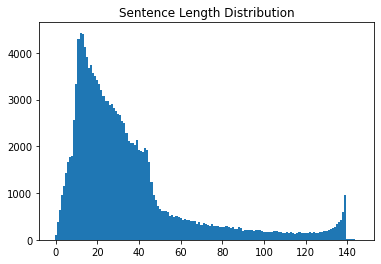

In [21]:
min_len = 999
max_len = 0
sum_len = 0

sentence_length_list = []

for sen in data:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length
    sentence_length_list.append(length)

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(data))

sentence_length = np.zeros((max_len), dtype=int)

for sen in data:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [22]:
def check_sentence_with_length(raw, length):
    count = 0
    
    for sen in raw:
        if len(sen) == length:
            print(sen)
            print("---")
            
            count += 1
            if count > 100: return

In [23]:
# 길이가 1인 문장 확인
check_sentence_with_length(data, 1)

아
---
잼
---
1
---
4
---
굿
---
짱
---
.
---
음
---
?
---
ㅎ
---
ㅋ
---
즐
---
♥
---
굳
---
네
---
ㅇ
---
ㅠ
---
쒯
---
♬
---
토
---
O
---
똥
---
z
---
헐
---
삼
---
꽝
---
풉
---
ㅅ
---
왜
---
ㄴ
---
쉣
---
봐
---
뿌
---
ㅜ
---
♡
---
ㅁ
---
0
---
ㅉ
---
d
---
흥
---
乃
---
찜
---
귯
---
린
---
시
---
ㅗ
---
a
---
c
---
흠
---
웅
---
오
---
9
---
쩜
---
애
---
헝
---
쨩
---
움
---
ㄳ
---
업
---
헉
---
군
---
b
---
;
---
g
---
올
---
걍
---
허
---
-
---
쀍
---
로
---
ㄹ
---
ㅂ
---
갑
---
즛
---
킥
---
함
---
진
---
ㅡ
---
잠
---
곧
---
ㅍ
---
·
---
캬
---
ㅆ
---
,
---
풋
---
ㄱ
---
파
---
ㄷ
---
웩
---
꺅
---
욜
---
ㅄ
---
2
---
핡
---


In [24]:
check_sentence_with_length(data, 2)

최고
---
졸작
---
대박
---
버려
---
망함
---
굳굳
---
안습
---
망작
---
ㅇㅇ
---
쵝오
---
굿!
---
별루
---
씐나
---
쓰렉
---
볼만
---
허접
---
비추
---
좋다
---
ㅎㅎ
---
아나
---
ㅉㅉ
---
야.
---
역시
---
^^
---
오오
---
평이
---
지루
---
오욈
---
ㅋㅋ
---
지송
---
별로
---
눈물
---
당연
---
쩔어
---
별노
---
몰입
---
졸잼
---
돋네
---
오글
---
이응
---
첨봄
---
최악
---
잼씀
---
ok
---
유후
---
감동
---
;;
---
조앙
---
1점
---
표절
---
명작
---
으휴
---
에효
---
gg
---
ㄱ굿
---
굿잡
---
잼나
---
10
---
ㅜㅜ
---
우왕
---
거지
---
굿굿
---
좋음
---
실망
---
애이
---
짱임
---
전설
---
mm
---
와우
---
등록
---
하위
---
그닥
---
뭉클
---
삼류
---
HN
---
윤하
---
섹시
---
실화
---
머냐
---
수작
---
꿀잼
---
동감
---
굿.
---
굳ㅋ
---
굳!
---
추천
---
좋아
---
55
---
안봐
---
개쩜
---
올레
---
난해
---
ㅠㅠ
---
뭐니
---
ㅁㅁ
---
뭥미
---
쓰랙
---
좇~
---
오우
---
미안
---
걸작
---


In [25]:
# 문장 길이가 140인 문장 확인
check_sentence_with_length(data,140)

데너리스 타르 가르엔...나도 용의주인이 되고 싶다...누이랑,근친상간이나 하고 다닐지라도,소설 속에선 제일 멋진 놈이 자이메 라니스터였는데,드라마속에선,드래곤(용)이 제일 멋지네(웃음)감독님 토르-2 다크 월드는 말아 잡수셨을지라도,기본 선방은 했음
---
아~ 진짜 조금만 더 손 좀 보면 왠만한 상업 영화 못지 않게 퀄리티 쩔게 만들어 질 수 있었는데 아쉽네요 그래도 충분히 재미있었습니다 개인적으로 조금만 더 잔인하게 더 자극적으로 노출씬도 화끈하게 했더라면 어땠을까 하는 국산영화라 많이 아낀 듯 보임
---
평점조절위원회에서 나왔습니다(웃음)김혜선은 @내일이 오면@의 김순정,순정이 역할이 제일이다.팜므파탈로써,그 정도까지 잘해낼 줄은,정말 의외였어...연기20년 한사람에게 요즘 사극에서 벌어지고 있는,그녀에 대한 연기논란은 왠지 코미디의한장면 같음(웃음)
---
사실여부를 떠나,알고왔던 아더와 너무 매칭이 안돼더라.원탁기사중 실제 검술 최고수는 랜슬롯으로 알고 있는데,트리스탄보다 못하고,싸우는 검술은 마치 중국검술 흉내낸거 같은게;; 그리고 란슬롯이 실제는 쌍검였나?너무 매칭이 안대 하튼 ㅋ기네비어역도 미스.
---
진짜 이건 아님ㅋㅋㅋㅋㅋ액션영화좋아해서 액션영화만 다운받아서 꾸준히 본게 벌써 몇년인 사람임 근데 이건 진짴ㅋㅋㅋㅋㅋㅋ아무리 점수 잘 줘도 100점 만점에 10점?ㅡㅡ돈주고봤는데너무아깝다진짜ㅜㅜ그리고대체 왜 13구역 타이틀을 달고나왔는지 모르겠음 실망
---
영화'산업'이라고 하잖는가? 이딴식으로 홍보 해놓고 속여서 팔았다는 게 소비자 입장에서는 짜증난다. 그나마 다행은 아주 싸구려를 상급품으로 속여판 게 아니라는 점. 그래서 1점. 차라리 연상호 감독 작품 처럼 홍보가 됐다면, 그 비슷하게 만이라도 하지
---
화려한 색채때문에 눈이 아프지만 그 나름대로 화려연예계여자욕망에대해 표현해냈던거같다 보는내내 진짜 리리코심정가진 연옌들도 있을거같고..나를한번도보지못하고알지못하는사람들이날어떻게사랑하냐그런대사 나왔을때 소름돋더라 연예인들은 많은사랑받으

In [26]:
min_val = np.percentile(sentence_length_list, 2.5)
max_val = np.percentile(sentence_length_list, 97.5)

In [27]:
min_val,max_val

(6.0, 132.0)

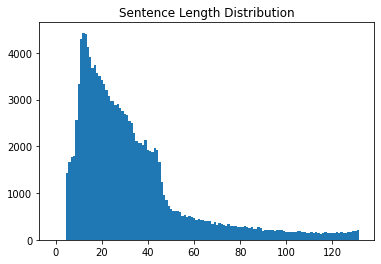

In [28]:
max_len = 132
min_len = 6

# 길이 조건에 맞는 문장만 선택합니다.
filtered_corpus = [s for s in data if (len(s) <= max_len) & (len(s) >= min_len)]

# 분포도를 다시 그려봅니다.
sentence_length = np.zeros((max_len), dtype=int)

for sen in filtered_corpus:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [29]:
len(filtered_corpus)

139384

중복은 제거한 194470데이터에서 사분위수의 약 95%인 max_len = 132, min_len=6으로 한다

In [30]:
df_filtered = df[df['document'].str.len().between(6, 132)]
df_filtered

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
...,...,...,...
149995,6222902,인간이 문제지.. 소는 뭔죄인가..,0
149996,8549745,평점이 너무 낮아서...,1
149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0
149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1


In [31]:
filtered_corpus = df_filtered['document']
filtered_label = df_filtered['label']

In [32]:
import sentencepiece as spm
import os
temp_file = os.getenv('HOME')+'/aiffel/project/GoingDeeper/Go01/korean-english-park.train.ko.temp'

vocab_size = 8000

with open(temp_file, 'w') as f:
    for row in filtered_corpus:   # 이전에 나왔던 정제했던 corpus를 활용해서 진행해야 합니다.
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm --vocab_size={}'.format(temp_file, vocab_size)    
)
#위 Train에서  --model_type = unigram이 디폴트 적용되어 있습니다. --model_type = bpe로 옵션을 주어 변경할 수 있습니다.

!ls -l korean_spm*

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=/aiffel/aiffel/project/GoingDeeper/Go01/korean-english-park.train.ko.temp --model_prefix=korean_spm --vocab_size=8000
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /aiffel/aiffel/project/GoingDeeper/Go01/korean-english-park.train.ko.temp
  input_format: 
  model_prefix: korean_spm
  model_type: UNIGRAM
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_voc

-rw-r--r-- 1 root root 374969 May  9 06:25 korean_spm.model
-rw-r--r-- 1 root root 144419 May  9 06:25 korean_spm.vocab


In [33]:
# 잘 됐는지 확인
s = spm.SentencePieceProcessor()
s.Load('korean_spm.model')

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s.DecodeIds(tokensIDs))

[1464, 10, 387, 15, 1430, 10, 151, 17, 4]
['▁아버지', '가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.


In [34]:
def sp_tokenize(s, corpus): 

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./korean_spm.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({word:idx})
        index_word.update({idx:word})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='pre')

    return tensor, word_index, index_word

In [35]:
tensor, word_index, index_word = sp_tokenize(s,filtered_corpus)

In [36]:
y = filtered_label.values

In [37]:
X_train = tensor
y_train = y.reshape(-1,1)


## 테스트 데이터

In [38]:
test_df = pd.read_csv("./ratings_test.txt",sep="\t")
test_df

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0
...,...,...,...
49995,4608761,오랜만에 평점 로긴했네ㅋㅋ 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함,1
49996,5308387,의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따 OOOO,0
49997,9072549,그림도 좋고 완성도도 높았지만... 보는 내내 불안하게 만든다,0
49998,5802125,절대 봐서는 안 될 영화.. 재미도 없고 기분만 잡치고.. 한 세트장에서 다 해먹네,0


In [39]:
test_df.isnull().sum()

id          0
document    3
label       0
dtype: int64

In [40]:
test_df.dropna(inplace=True)

In [41]:
test_df.isnull().sum()

id          0
document    0
label       0
dtype: int64

In [42]:
test_data = test_df['document'].values
test_label = test_df['label'].values

In [43]:
test_tensor, word_index, index_word = sp_tokenize(s,test_data)

## lstm 모델

In [47]:
# vocab_size = 8000
embedding_dim = 32
lstm_units = 64
dense_units = 32

lstm_model = tf.keras.Sequential()
lstm_model.add(tf.keras.layers.Embedding(vocab_size, embedding_dim, input_shape=(None,)))
lstm_model.add(tf.keras.layers.LSTM(lstm_units, return_sequences=True))
lstm_model.add(tf.keras.layers.LSTM(lstm_units))   
lstm_model.add(tf.keras.layers.Dense(dense_units, activation='relu'))
lstm_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          256000    
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 64)          24832     
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 315,969
Trainable params: 315,969
Non-trainable params: 0
_________________________________________________________________


In [48]:
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [49]:
# 모델 학습
from tensorflow.keras.callbacks import EarlyStopping
epochs = 30

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

lstm_model.fit(X_train, y_train , 
              epochs=epochs, batch_size=512, 
              validation_split=0.2, callbacks=[early_stopping], verbose=1)


Epoch 1/30
218/218 [==============================] - 8s 23ms/step - loss: 0.4472 - accuracy: 0.7782 - val_loss: 0.3539 - val_accuracy: 0.8470
Epoch 2/30
218/218 [==============================] - 4s 20ms/step - loss: 0.3264 - accuracy: 0.8589 - val_loss: 0.3405 - val_accuracy: 0.8557
Epoch 3/30
218/218 [==============================] - 4s 20ms/step - loss: 0.3068 - accuracy: 0.8693 - val_loss: 0.3337 - val_accuracy: 0.8547
Epoch 4/30
218/218 [==============================] - 4s 20ms/step - loss: 0.2883 - accuracy: 0.8784 - val_loss: 0.3367 - val_accuracy: 0.8544
Epoch 5/30
218/218 [==============================] - 4s 20ms/step - loss: 0.2715 - accuracy: 0.8861 - val_loss: 0.3433 - val_accuracy: 0.8539
Epoch 6/30
218/218 [==============================] - 4s 20ms/step - loss: 0.2546 - accuracy: 0.8947 - val_loss: 0.3500 - val_accuracy: 0.8522


In [50]:
lstm_results = lstm_model.evaluate(test_tensor,test_label,verbose=2)
print(lstm_results)

1563/1563 - 7s - loss: 0.3465 - accuracy: 0.8486
[0.3464958965778351, 0.8485709428787231]


### 다른 토크나이저 - mecab

In [51]:
from konlpy.tag import Mecab
mecab = Mecab()

In [52]:
# 위에서 사용한 코드를 활용해 MeCab 단어 사전을 만들어보세요. 
# Hint : mecab.morphs()를 사용해서 형태소분석을 합니다.
def mecab_split(sentence):
    # 코드를 작성하세요
    return mecab.morphs(sentence)

mecab_corpus = []

for kor in filtered_corpus:
    # 코드를 작성하세요
    mecab_corpus.append(mecab_split(kor))

In [53]:
# 단어 사전과 Tensor 데이터 
def tokenize(corpus):  # corpus: Tokenized Sentence's List
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='pre')

    return tensor, tokenizer

In [54]:
mecab_tensor, mecab_tokenizer = tokenize(mecab_corpus)

In [67]:
# vocab_size = 8000
embedding_dim = 32
lstm_units = 64
dense_units = 32

lstm_model_mecab = tf.keras.Sequential()
lstm_model_mecab.add(tf.keras.layers.Embedding(vocab_size, embedding_dim, input_shape=(None,)))
lstm_model_mecab.add(tf.keras.layers.LSTM(lstm_units, return_sequences=True))
lstm_model_mecab.add(tf.keras.layers.LSTM(lstm_units))   
lstm_model_mecab.add(tf.keras.layers.Dense(dense_units, activation='relu'))
lstm_model_mecab.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

lstm_model_mecab.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 32)          256000    
_________________________________________________________________
lstm_8 (LSTM)                (None, None, 64)          24832     
_________________________________________________________________
lstm_9 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_8 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 33        
Total params: 315,969
Trainable params: 315,969
Non-trainable params: 0
_________________________________________________________________


In [68]:
lstm_model_mecab.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [69]:
# 모델 학습

epochs = 30

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

lstm_model_mecab.fit(mecab_tensor, y_train , 
              epochs=epochs, batch_size=512, 
              validation_split=0.2, callbacks=[early_stopping], verbose=1)


Epoch 1/30
218/218 [==============================] - 7s 21ms/step - loss: 0.4340 - accuracy: 0.7925 - val_loss: 0.3539 - val_accuracy: 0.8476
Epoch 2/30
218/218 [==============================] - 4s 18ms/step - loss: 0.3300 - accuracy: 0.8581 - val_loss: 0.3471 - val_accuracy: 0.8506
Epoch 3/30
218/218 [==============================] - 4s 18ms/step - loss: 0.3092 - accuracy: 0.8688 - val_loss: 0.3380 - val_accuracy: 0.8537
Epoch 4/30
218/218 [==============================] - 4s 19ms/step - loss: 0.2887 - accuracy: 0.8789 - val_loss: 0.3340 - val_accuracy: 0.8563
Epoch 5/30
218/218 [==============================] - 4s 19ms/step - loss: 0.2668 - accuracy: 0.8890 - val_loss: 0.3380 - val_accuracy: 0.8544
Epoch 6/30
218/218 [==============================] - 4s 19ms/step - loss: 0.2465 - accuracy: 0.8983 - val_loss: 0.3464 - val_accuracy: 0.8590
Epoch 7/30
218/218 [==============================] - 4s 19ms/step - loss: 0.2272 - accuracy: 0.9071 - val_loss: 0.3525 - val_accuracy: 0.8572

In [62]:
mecab_corpus_test = []

for kor in test_data:
    # 코드를 작성하세요
    mecab_corpus_test.append(mecab_split(kor))

In [63]:
mecab_tensor_test, mecab_tokenizer = tokenize(mecab_corpus_test)

In [70]:
lstm_results_mecab = lstm_model_mecab.evaluate(mecab_tensor_test,test_label,verbose=2)
print(lstm_results_mecab)

1563/1563 - 7s - loss: 1.0290 - accuracy: 0.5426
[1.029029369354248, 0.542572557926178]


### komoran

In [72]:
from konlpy.tag import Komoran
komoran = Komoran()

In [73]:
def komoran_split(sentence):
    # 코드를 작성하세요
    return komoran.morphs(sentence)

komoran_corpus = []

for kor in filtered_corpus:
    # 코드를 작성하세요
    komoran_corpus.append(komoran_split(kor))

In [74]:
komoran_corpus_test = []
for kor in test_data:
    komoran_corpus_test.append(komoran_split(kor))

In [75]:
komoran_tensor, komoran_tokenizer = tokenize(komoran_corpus)

In [76]:
komoran_tensor_test, komoran_tokenizer = tokenize(komoran_corpus_test)

In [77]:
# vocab_size = 8000
embedding_dim = 32
lstm_units = 64
dense_units = 32

lstm_model_komoran = tf.keras.Sequential()
lstm_model_komoran.add(tf.keras.layers.Embedding(vocab_size, embedding_dim, input_shape=(None,)))
lstm_model_komoran.add(tf.keras.layers.LSTM(lstm_units, return_sequences=True))
lstm_model_komoran.add(tf.keras.layers.LSTM(lstm_units))   
lstm_model_komoran.add(tf.keras.layers.Dense(dense_units, activation='relu'))
lstm_model_komoran.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

lstm_model_komoran.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 32)          256000    
_________________________________________________________________
lstm_10 (LSTM)               (None, None, 64)          24832     
_________________________________________________________________
lstm_11 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dense_10 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 33        
Total params: 315,969
Trainable params: 315,969
Non-trainable params: 0
_________________________________________________________________


In [78]:
lstm_model_komoran.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [79]:
# 모델 학습

epochs = 30

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

lstm_model_komoran.fit(komoran_tensor, y_train , 
              epochs=epochs, batch_size=512, 
              validation_split=0.2, callbacks=[early_stopping], verbose=1)


Epoch 1/30
218/218 [==============================] - 8s 22ms/step - loss: 0.4496 - accuracy: 0.7814 - val_loss: 0.3702 - val_accuracy: 0.8376
Epoch 2/30
218/218 [==============================] - 4s 19ms/step - loss: 0.3512 - accuracy: 0.8462 - val_loss: 0.3617 - val_accuracy: 0.8415
Epoch 3/30
218/218 [==============================] - 4s 19ms/step - loss: 0.3331 - accuracy: 0.8556 - val_loss: 0.3584 - val_accuracy: 0.8413
Epoch 4/30
218/218 [==============================] - 4s 19ms/step - loss: 0.3165 - accuracy: 0.8639 - val_loss: 0.3529 - val_accuracy: 0.8444
Epoch 5/30
218/218 [==============================] - 4s 20ms/step - loss: 0.2980 - accuracy: 0.8716 - val_loss: 0.3481 - val_accuracy: 0.8485
Epoch 6/30
218/218 [==============================] - 4s 20ms/step - loss: 0.2779 - accuracy: 0.8817 - val_loss: 0.3529 - val_accuracy: 0.8459
Epoch 7/30
218/218 [==============================] - 4s 20ms/step - loss: 0.2601 - accuracy: 0.8906 - val_loss: 0.3677 - val_accuracy: 0.8501

In [82]:
lstm_results_komoran = lstm_model_komoran.evaluate(komoran_tensor_test,test_label,verbose=2)
print(lstm_results_komoran)

1563/1563 - 7s - loss: 1.0343 - accuracy: 0.5470
[1.034342885017395, 0.5469728112220764]


# 회고

코드 정리가 필요하다.  
lstm이 단층이었을 때와 2층이었을때의 성능 차이가 있었다. 0.5 -> 0.8  
mecab, komoran의 test 데이터에서 성능이 나오지 않는게 의문이다.  